<h1 style="text-align: center; color:rgb(254, 255, 255);">Insider Trades Analysis</h1>

### Automatic data collection with github actions

Scrape SEC form 4 insider purchases over $500k

Calculate the change in price of the stock in 24h, 1 week and 1 month after the filing date.

In [12]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
import time

# Load environment variables from .env file
load_dotenv()

def get_historical_price(ticker, retries=3, delay=5):
    """
    Get historical price data for a ticker using yfinance
    
    Args:
        ticker (str): Stock ticker symbol
        retries (int): Number of retry attempts
        delay (int): Delay between retries in seconds
    
    Returns:
        pd.DataFrame: DataFrame with historical price data
    """
    stock = yf.Ticker(ticker)
    for attempt in range(retries):
        try:
            data = stock.history(period="max")
            # Convert timezone-aware index to timezone-naive
            data.index = data.index.tz_localize(None)
            return data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            if attempt < retries - 1:
                print(f"Retrying... ({attempt + 1}/{retries})")
                time.sleep(delay)
            else:
                print(f"Failed to fetch data for {ticker} after {retries} attempts.")
                return pd.DataFrame()

def find_closest_date_price(time_series, target_date, max_days_diff=7):
    """
    Find the closing price for the date closest to the target date
    
    Args:
        time_series (pd.DataFrame): DataFrame with price data
        target_date (datetime): Target date to find price for
        max_days_diff (int): Maximum number of days difference to consider
        
    Returns:
        tuple: (price, actual_date) or (None, None) if no suitable date found
    """
    if not time_series.empty:
        closest_date = None
        closest_diff = float('inf')
        
        for date in time_series.index:
            # Ensure both dates are timezone-naive for comparison
            date_naive = date.replace(tzinfo=None) if hasattr(date, 'tzinfo') else date
            target_naive = target_date.replace(tzinfo=None) if hasattr(target_date, 'tzinfo') else target_date
            
            diff = abs((date_naive - target_naive).days)
            if diff <= max_days_diff and diff < closest_diff:
                closest_diff = diff
                closest_date = date
                
        if closest_date:
            price = time_series.loc[closest_date]['Close']
            return price, closest_date
    
    return None, None

def calculate_price_changes(input_file, output_file):
    """
    Calculate price changes for insider buys and write results to a new CSV
    
    Args:
        input_file (str): Path to input CSV file
        output_file (str): Path to output CSV file
        
    Returns:
        pd.DataFrame: DataFrame with calculated price changes
    """
    # Check if output file exists and load it
    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
        existing_df['Filing Date'] = pd.to_datetime(existing_df['Filing Date'])
        
        # Create a dictionary to quickly find existing records
        existing_records = {}
        for idx, row in existing_df.iterrows():
            key = f"{row['Filing Date'].strftime('%Y-%m-%d')}_{row['Ticker']}_{row['Insider Name']}"
            existing_records[key] = {
                '24h_Change_%': row['24h_Change_%'] if not pd.isna(row['24h_Change_%']) else None,
                '1w_Change_%': row['1w_Change_%'] if not pd.isna(row['1w_Change_%']) else None,
                '1m_Change_%': row['1m_Change_%'] if not pd.isna(row['1m_Change_%']) else None
            }
    else:
        existing_records = {}
    
    # Load and prepare input data
    df = pd.read_csv(input_file)
    df['Filing Date'] = pd.to_datetime(df['Filing Date'])
    
    # Add or ensure columns for percentage changes
    if '24h_Change_%' not in df.columns:
        df['24h_Change_%'] = None
    if '1w_Change_%' not in df.columns:
        df['1w_Change_%'] = None
    if '1m_Change_%' not in df.columns:
        df['1m_Change_%'] = None
    
    # Get current time (timezone-naive)
    current_time = datetime.now()
    
    # Group by ticker to minimize API calls
    ticker_groups = df.groupby('Ticker')
    
    for ticker, group in ticker_groups:
        # Check if we need to update any records for this ticker
        needs_update = False
        for idx, row in group.iterrows():
            filing_date = row['Filing Date']
            key = f"{filing_date.strftime('%Y-%m-%d')}_{ticker}_{row['Insider Name']}"
            
            # Skip if we already have complete data for this record
            if key in existing_records:
                record = existing_records[key]
                if (record['24h_Change_%'] is not None and 
                    record['1w_Change_%'] is not None and 
                    record['1m_Change_%'] is not None):
                    # Copy existing values to the dataframe
                    df.at[idx, '24h_Change_%'] = record['24h_Change_%']
                    df.at[idx, '1w_Change_%'] = record['1w_Change_%']
                    df.at[idx, '1m_Change_%'] = record['1m_Change_%']
                    continue
                    
            # Calculate target dates
            h24_target = filing_date + timedelta(days=1)
            w1_target = filing_date + timedelta(days=7)
            m1_target = filing_date + timedelta(days=30)
            
            # Check if any time periods need updating
            if ((h24_target <= current_time and (key not in existing_records or existing_records[key]['24h_Change_%'] is None)) or
                (w1_target <= current_time and (key not in existing_records or existing_records[key]['1w_Change_%'] is None)) or
                (m1_target <= current_time and (key not in existing_records or existing_records[key]['1m_Change_%'] is None))):
                needs_update = True
                break
        
        # Skip API call if no updates needed
        if not needs_update:
            continue
            
        # Get price data once per ticker
        print(f"Fetching data for {ticker}...")
        time_series = get_historical_price(ticker)
        
        # Process each row in the ticker group
        for idx, row in group.iterrows():
            try:
                filing_date = row['Filing Date']
                key = f"{filing_date.strftime('%Y-%m-%d')}_{ticker}_{row['Insider Name']}"
                
                # If we have existing data, copy it first
                if key in existing_records:
                    record = existing_records[key]
                    if record['24h_Change_%'] is not None:
                        df.at[idx, '24h_Change_%'] = record['24h_Change_%']
                    if record['1w_Change_%'] is not None:
                        df.at[idx, '1w_Change_%'] = record['1w_Change_%']
                    if record['1m_Change_%'] is not None:
                        df.at[idx, '1m_Change_%'] = record['1m_Change_%']
                
                # Get base price for calculations
                base_price = row['Price Bought'] if not pd.isna(row['Price Bought']) else row['Transaction Price']
                
                if pd.isna(base_price):
                    print(f"No base price available for {ticker} on {filing_date.strftime('%Y-%m-%d')}")
                    continue
                    
                base_price = float(base_price)
                
                # Calculate target dates (all timezone-naive)
                h24_target = filing_date + timedelta(days=1)
                w1_target = filing_date + timedelta(days=7)
                m1_target = filing_date + timedelta(days=30)
                
                # Check and update 24h change if needed
                if h24_target <= current_time and pd.isna(df.at[idx, '24h_Change_%']):
                    price, _ = find_closest_date_price(time_series, h24_target)
                    if price is not None:
                        change = round(((price - base_price) / base_price) * 100, 2)
                        df.at[idx, '24h_Change_%'] = f"{'+' if change >= 0 else ''}{change}%"
                
                # Check and update 1w change if needed
                if w1_target <= current_time and pd.isna(df.at[idx, '1w_Change_%']):
                    price, _ = find_closest_date_price(time_series, w1_target)
                    if price is not None:
                        change = round(((price - base_price) / base_price) * 100, 2)
                        df.at[idx, '1w_Change_%'] = f"{'+' if change >= 0 else ''}{change}%"
                
                # Check and update 1m change if needed
                if m1_target <= current_time and pd.isna(df.at[idx, '1m_Change_%']):
                    price, _ = find_closest_date_price(time_series, m1_target)
                    if price is not None:
                        change = round(((price - base_price) / base_price) * 100, 2)
                        df.at[idx, '1m_Change_%'] = f"{'+' if change >= 0 else ''}{change}%"
                
            except Exception as e:
                print(f"Error processing row for {ticker}: {str(e)}")
                continue
    
    # Save the updated data
    df.to_csv(output_file, index=False)
    print(f"Analysis complete. Results saved to {output_file}")
    
    return df

# Execute the analysis
if __name__ == "__main__":
    input_file = 'Scraping/insider_buys.csv'
    output_file = 'Scraping/insider_buys_analysis.csv'
    
    analysis_df = calculate_price_changes(input_file, output_file)
    pd.set_option('display.max_rows', None)

$FERA: possibly delisted; no timezone found


Fetching data for FERA...
Error fetching data for FERA: 'Index' object has no attribute 'tz_localize'
Retrying... (1/3)


$FERA: possibly delisted; no timezone found


Error fetching data for FERA: 'Index' object has no attribute 'tz_localize'
Retrying... (2/3)


KeyboardInterrupt: 

Calculating averages for the change in price of the stock in 24h, 1 week and 1 month after the filing date.

In [15]:
import pandas as pd

def calculate_averages_from_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert percentage strings to numbers
    def convert_percentage(x):
        if pd.isna(x):
            return None
        return float(x.strip('%').replace('+', ''))
    
    # Convert percentages to numbers for all columns
    h24_changes = df['24h_Change_%'].apply(convert_percentage)
    w1_changes = df['1w_Change_%'].apply(convert_percentage)
    m1_changes = df['1m_Change_%'].apply(convert_percentage)
    
    # Calculate averages
    h24_avg = h24_changes.mean()
    w1_avg = w1_changes.mean()
    m1_avg = m1_changes.mean()
    
    # Calculate win rates (excluding None values)
    h24_winrate = (h24_changes[h24_changes.notna()] > 0).mean() * 100 if not h24_changes.empty else None
    w1_winrate = (w1_changes[w1_changes.notna()] > 0).mean() * 100 if not w1_changes.empty else None
    m1_winrate = (m1_changes[m1_changes.notna()] > 0).mean() * 100 if not m1_changes.empty else None
    
    print("Average Changes:")
    print(f"24 Hours: {'+' if h24_avg >= 0 else ''}{h24_avg:.2f}% (Win Rate: {h24_winrate:.1f}%)")
    if not pd.isna(w1_avg):
        print(f"1 Week:   {'+' if w1_avg >= 0 else ''}{w1_avg:.2f}% (Win Rate: {w1_winrate:.1f}%)")
    if not pd.isna(m1_avg):
        print(f"1 Month:  {'+' if m1_avg >= 0 else ''}{m1_avg:.2f}% (Win Rate: {m1_winrate:.1f}%)")

# Example usage
file_path = 'c:/Users/Albert/OneDrive/Desktop/Info/Projects/Insider_Trades/Scraping/insider_buys_analysis.csv'
calculate_averages_from_csv(file_path)

Average Changes:
24 Hours: +0.62% (Win Rate: 53.8%)
1 Week:   +0.39% (Win Rate: 47.3%)
1 Month:  -13.45% (Win Rate: 20.0%)


C:\Users\Albert\AppData\Local\Temp\ipykernel_14372\3946682557.py:194: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['24h', '1w', '1m'])



Statistical Summary:

24-Hour Returns:
count    72.000000
mean      1.377222
std       4.826424
min      -9.610000
25%      -1.377500
50%       0.400000
75%       3.387500
max      16.310000
Name: 24h_Change_num, dtype: float64

1-Week Returns:
count    37.000000
mean     -1.326216
std       9.309544
min     -20.120000
25%      -4.930000
50%      -0.450000
75%       3.890000
max      23.970000
Name: 1w_Change_num, dtype: float64

1-Month Returns:
count     5.000000
mean    -13.816000
std      10.311936
min     -28.560000
25%     -19.020000
50%     -12.770000
75%      -5.120000
max      -3.610000
Name: 1m_Change_num, dtype: float64

Insider Correlation Analysis:

Top 5 Insiders by Timing (min 2 trades):
                          Avg Return  Trades  Win Rate
Insider Name                                          
Broadwood Partners, L.P.        9.85       2      1.00
Whitesell Patrick               1.40       2      0.50
Johnson Lloyd Emerson           1.11       2      0.50
Smith David 

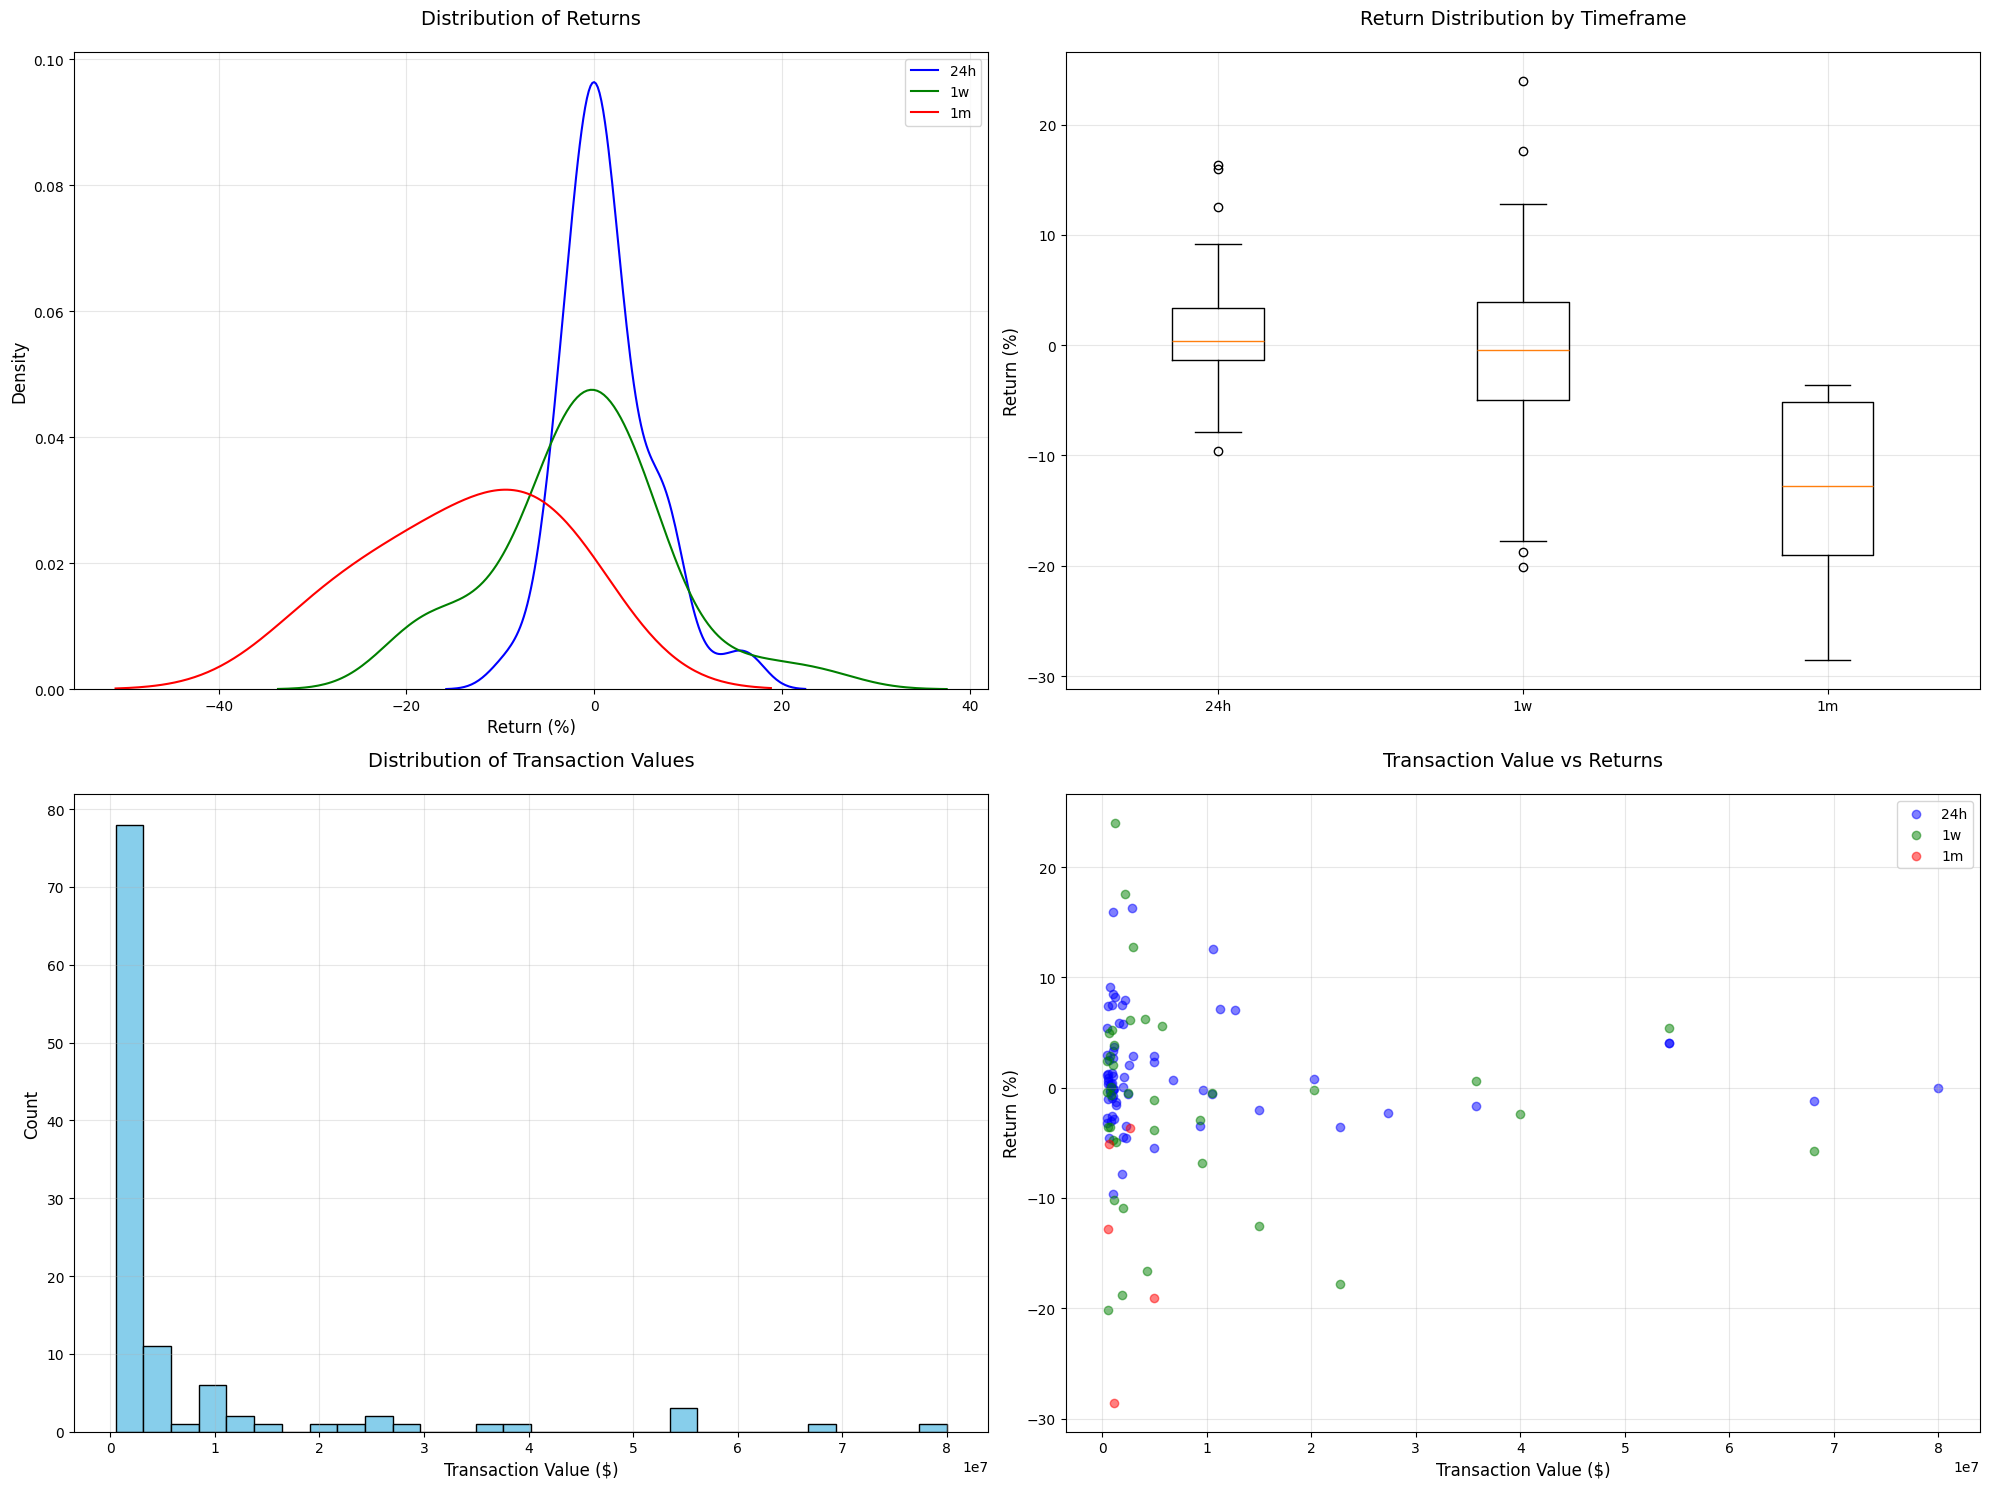

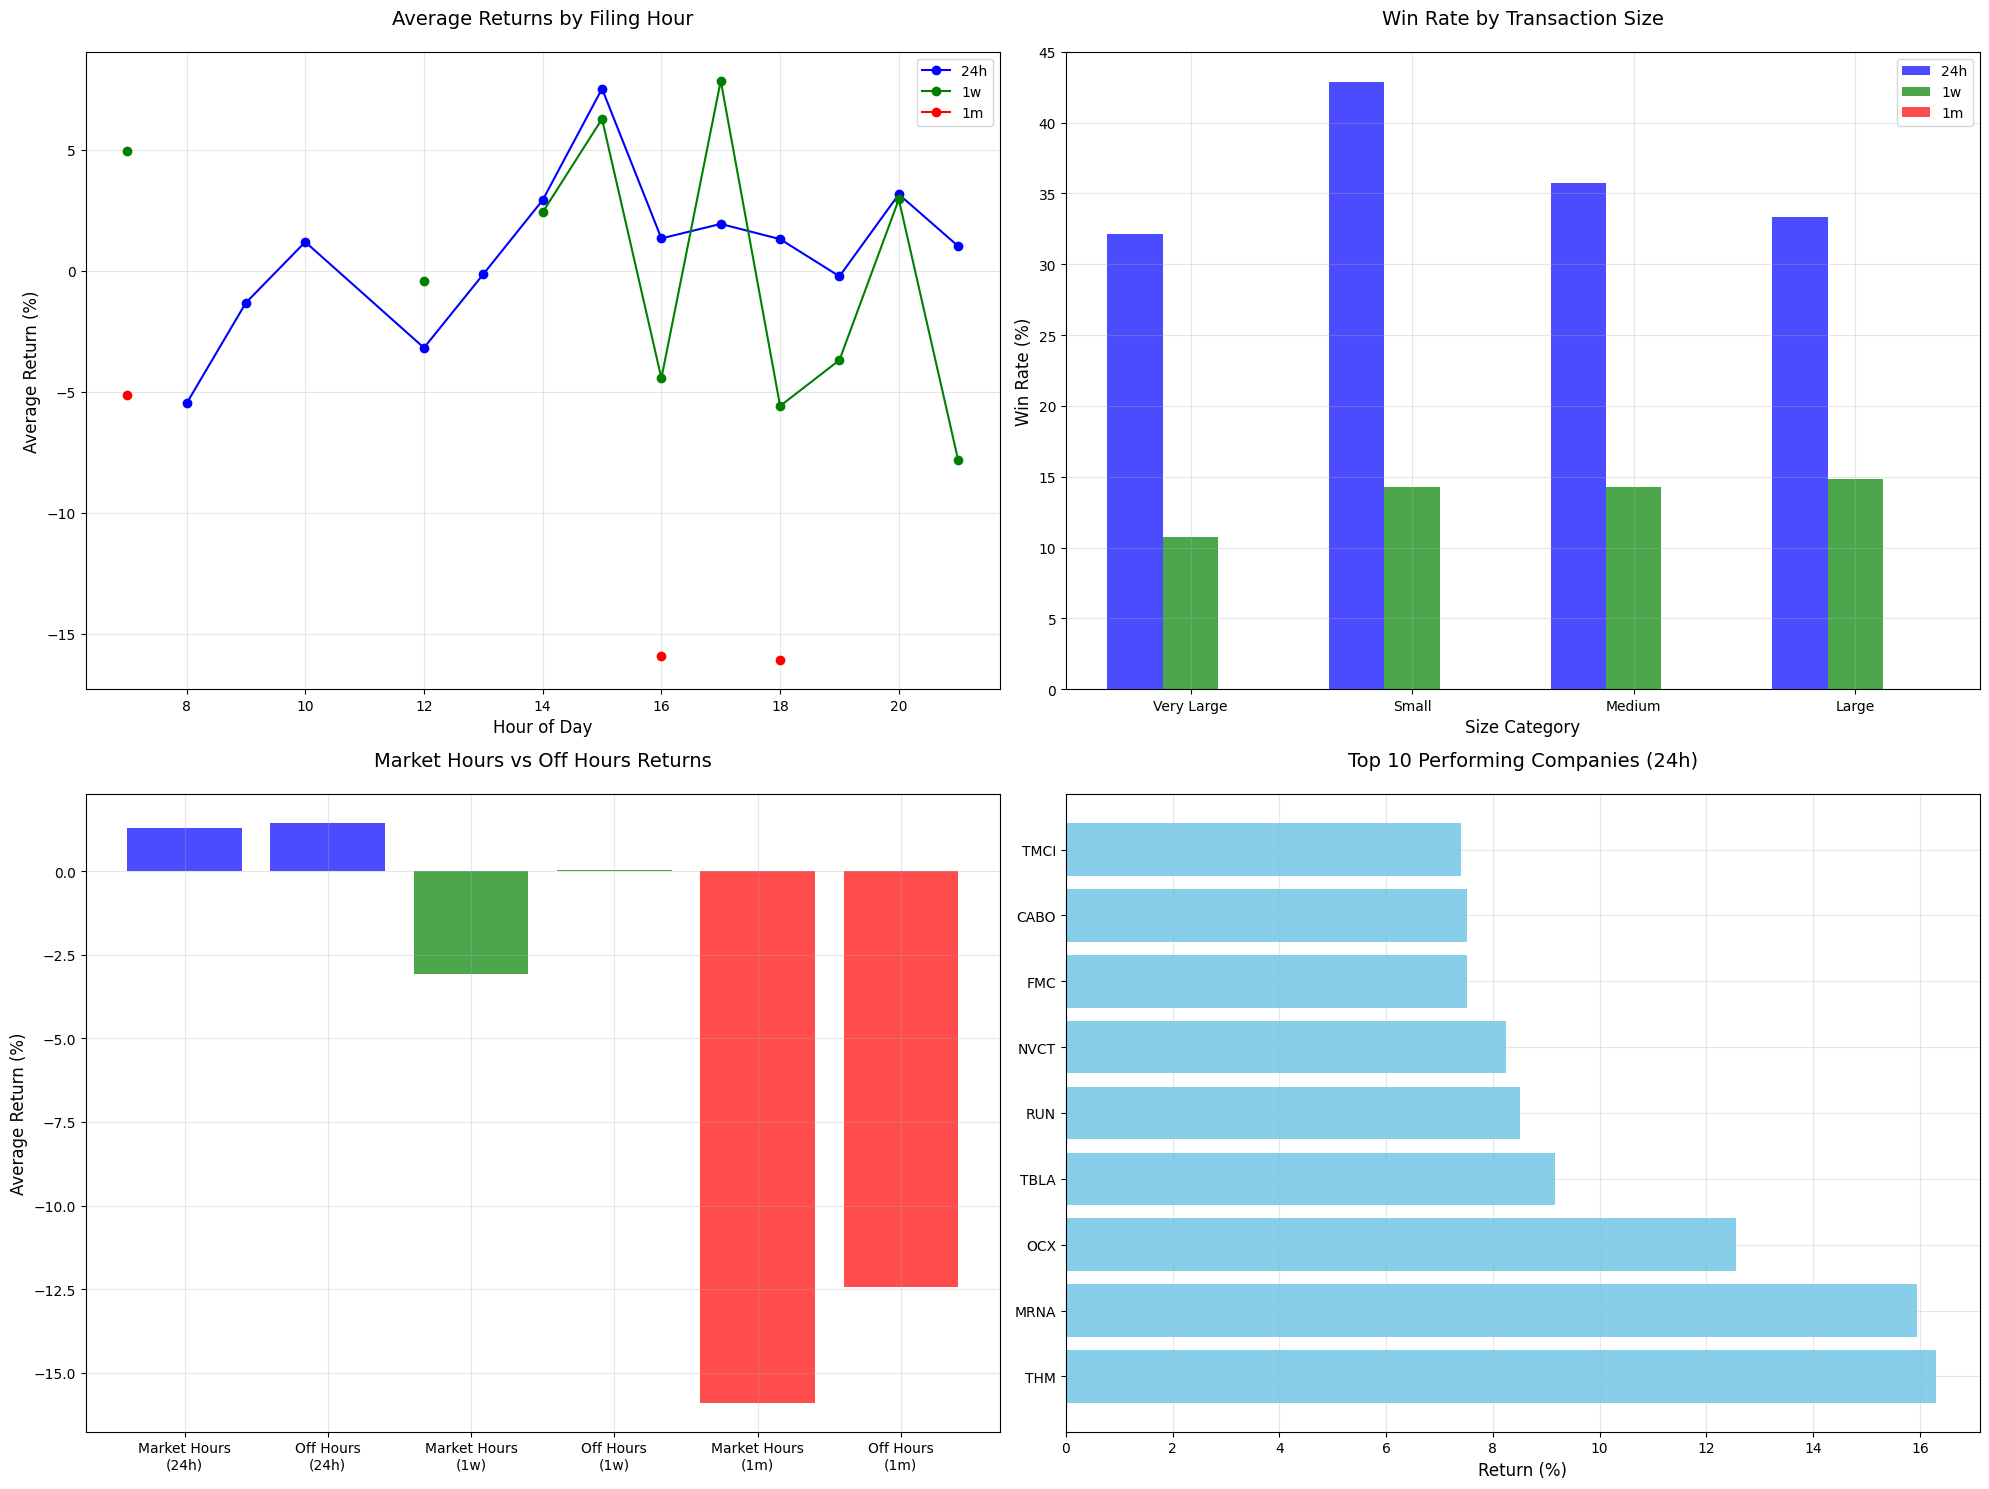

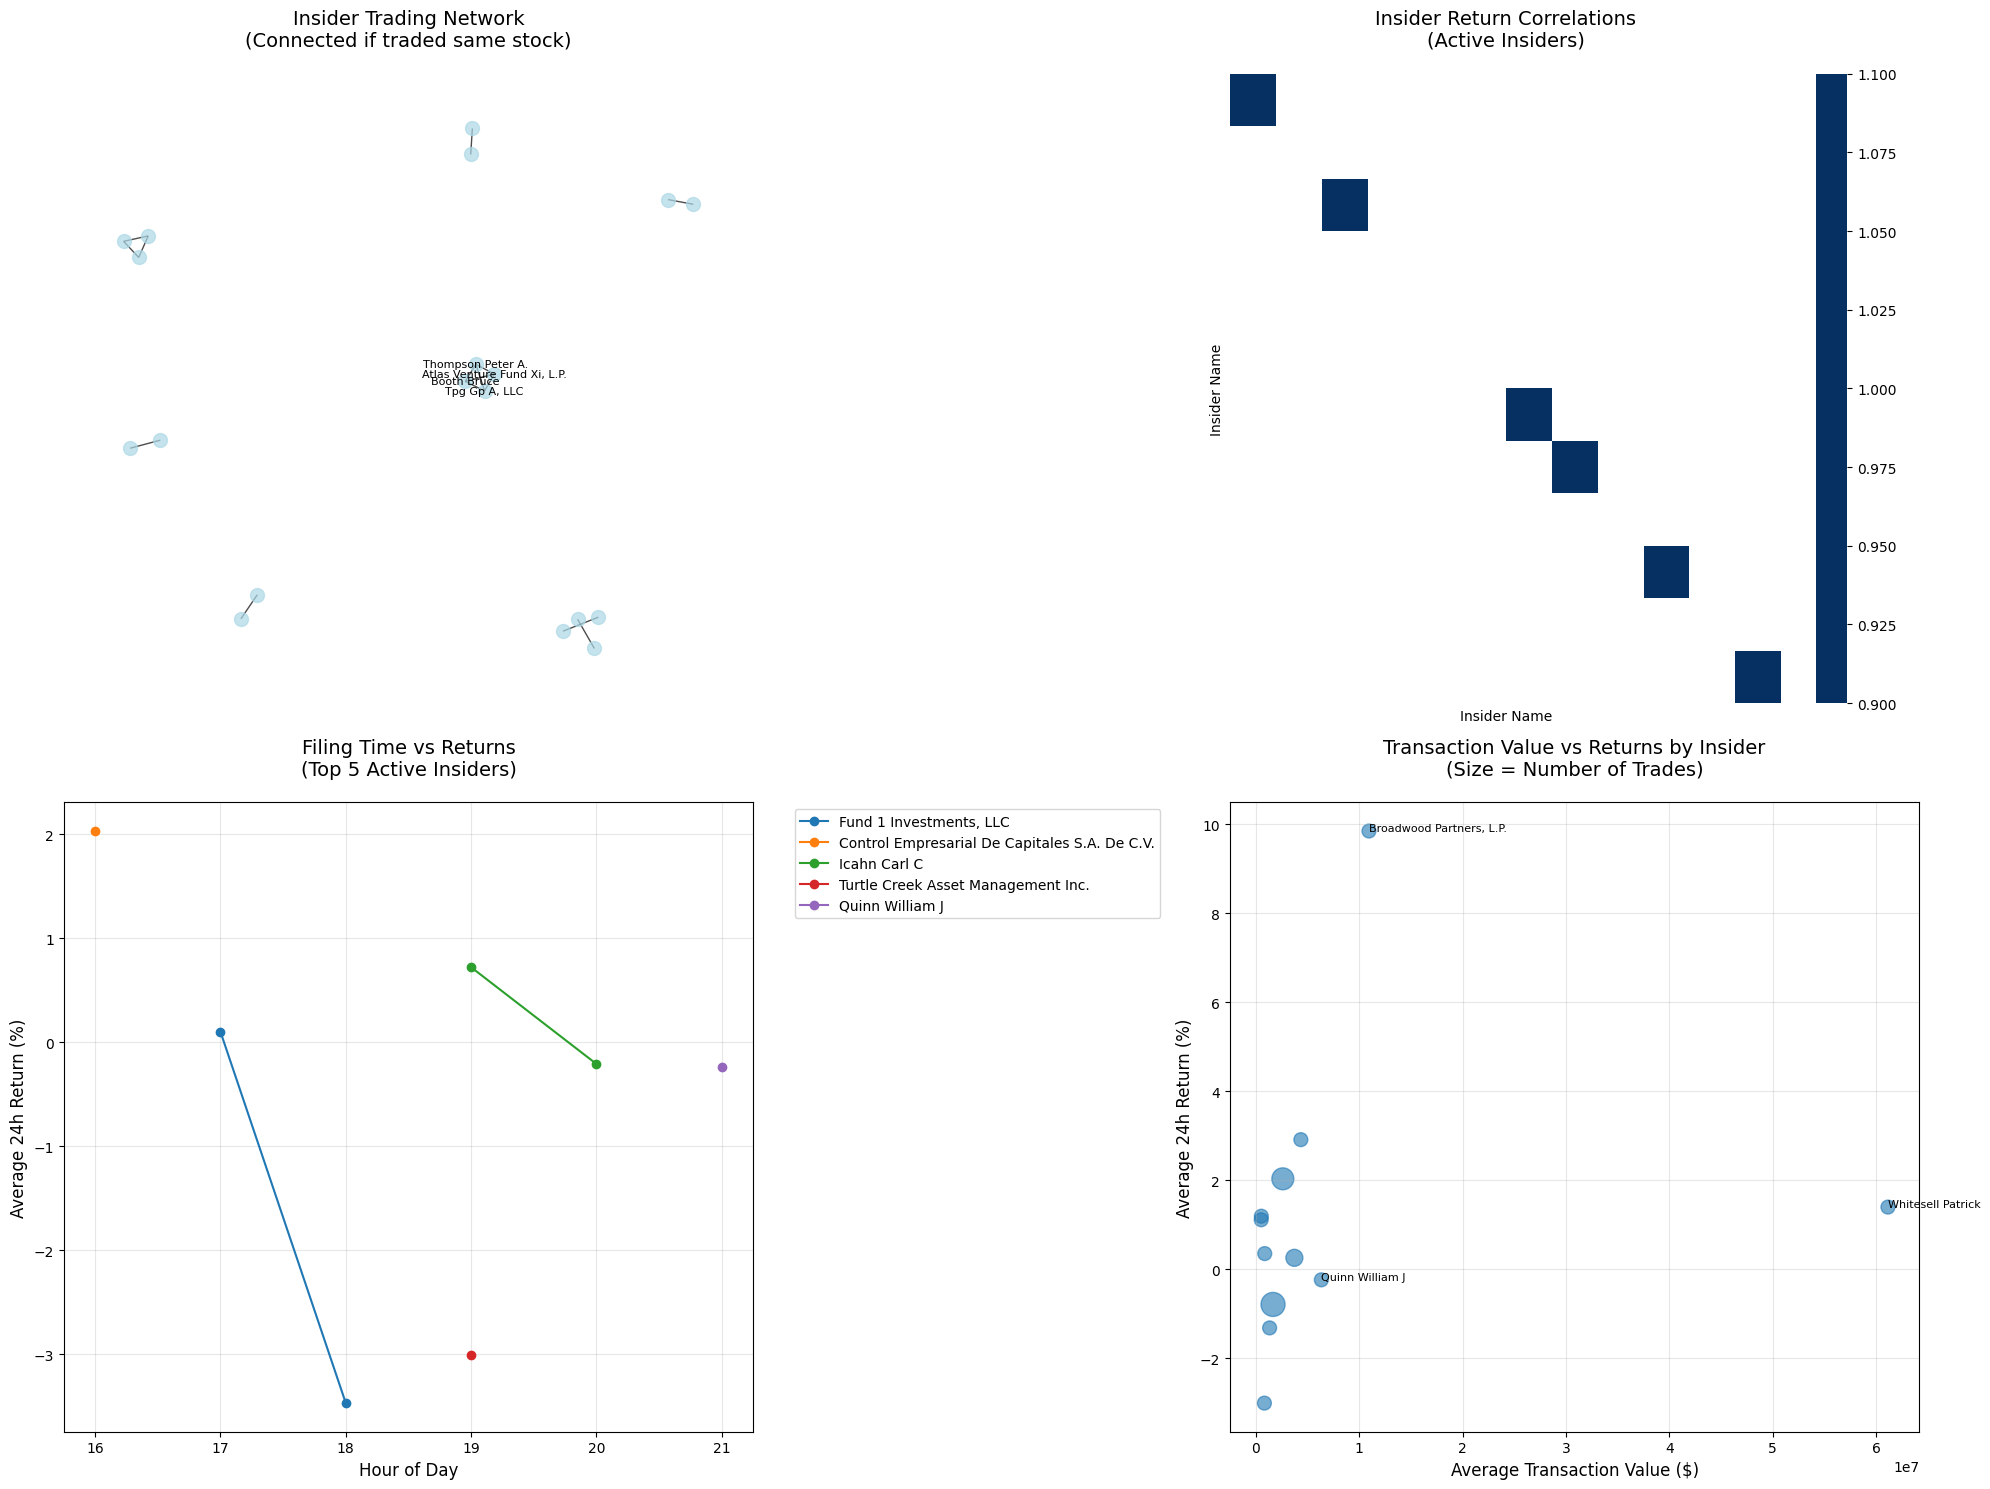

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import networkx as nx
import requests
from bs4 import BeautifulSoup
import logging
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Determine the script directory
try:
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    script_dir = os.getcwd()  # Use current working directory if running in a Jupyter Notebook

log_file = os.path.join(script_dir, 'insider_scraping.log')
csv_file = os.path.join(script_dir, 'insider_buys.csv')

# Set up logging with FileHandler to ensure append mode
logger = logging.getLogger('insider_scraper')
logger.setLevel(logging.INFO)

# Check if logger already has handlers to avoid duplicate handlers
if not logger.handlers:
    handler = logging.FileHandler(log_file, mode='a')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

# Add console handler
if not logger.handlers:
    # File handler (existing code)
    file_handler = logging.FileHandler(log_file, mode='a')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    
    # Console handler
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
"""
def scrape_insider_buys():
    try:
        # Create or load existing CSV
        if os.path.exists(csv_file):
            existing_df = pd.read_csv(csv_file)
            # Convert Filing Date to datetime for comparison
            existing_df['Filing Date'] = pd.to_datetime(existing_df['Filing Date'])
        else:
            existing_df = pd.DataFrame()
        
        url = "http://openinsider.com/insider-purchases"
        
        # Add headers to mimic a browser request
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        # Make the request
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        # Parse the HTML
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find the main table
        table = soup.find('table', {'class': 'tinytable'})
        
        # Initialize lists to store data
        data = []
        
        # Process each row
        for row in table.find_all('tr')[1:]:  # Skip header row
            cols = row.find_all('td')
            if len(cols) > 0:
                filing_date = cols[1].text.strip()
                # Verify the date format and ensure it's not in the future
                try:
                    filing_datetime = datetime.strptime(filing_date, '%Y-%m-%d %H:%M:%S')
                    if filing_datetime > datetime.now():
                        logger.error(f"Future date detected: {filing_date}, skipping entry")
                        continue
                except ValueError as e:
                    logger.error(f"Date parsing error: {e}")
                    continue
                    
                ticker = cols[3].text.strip()
                company_name = cols[4].text.strip()
                insider_name = cols[5].text.strip()
                transaction_price = float(cols[8].text.strip().replace('$', '').replace(',', ''))
                value = float(cols[12].text.strip().replace('$', '').replace('+', '').replace(',', ''))
                
                # Only process if value is over $500,000
                if value >= 500000:
                    data.append({
                        'Filing Date': filing_date,
                        'Ticker': ticker,
                        'Company Name': company_name,
                        'Insider Name': insider_name,  # Add insider name to the data
                        'Transaction Price': transaction_price,
                        'Price Bought': None,  # Placeholder for Price Bought
                        'Value': int(round(value))  # Round value to integer
                    })
        
        # Create DataFrame from new data
        new_df = pd.DataFrame(data)
        
        if not existing_df.empty:
            # Convert Filing Date to datetime for comparison
            new_df['Filing Date'] = pd.to_datetime(new_df['Filing Date'])
            
            # Exclude empty or all-NA columns before concatenation
            existing_df = existing_df.dropna(axis=1, how='all')
            new_df = new_df.dropna(axis=1, how='all')
            
            # Combine existing and new data
            combined_df = pd.concat([existing_df, new_df])
            
            # Keep only the first transaction per company per day
            combined_df['Filing_Date_Only'] = combined_df['Filing Date'].dt.date
            combined_df = combined_df.sort_values('Filing Date', ascending=True)  # Sort ascending to keep first
            combined_df = combined_df.drop_duplicates(
                subset=['Filing_Date_Only', 'Company Name'],
                keep='first'
            )
            combined_df = combined_df.drop('Filing_Date_Only', axis=1)  # Remove helper column
            
            # Sort by Filing Date (most recent first)
            combined_df = combined_df.sort_values('Filing Date', ascending=False)
            
            # Save combined data
            combined_df.to_csv(csv_file, index=False)
            logger.info(f"Updated existing file with {len(new_df)} new entries")
        else:
            # If no existing file, save new data
            new_df.to_csv(csv_file, index=False)
            logger.info(f"Created new file with {len(new_df)} entries")
        
        return combined_df if not existing_df.empty else new_df
        
    except Exception as e:
        logger.error(f"Error scraping website: {str(e)}")
        raise
"""
def analyze_and_visualize_trades():
    # Read the data
    df = pd.read_csv('Analysis/insider_buys_analysis.csv')
    df['Filing Date'] = pd.to_datetime(df['Filing Date'])
    
    # Convert percentage strings to numbers for analysis
    def convert_percentage(x):
        if pd.isna(x):
            return None
        return float(str(x).strip('%').replace('+', ''))
    
    df['24h_Change_num'] = df['24h_Change_%'].apply(convert_percentage)
    df['1w_Change_num'] = df['1w_Change_%'].apply(convert_percentage)
    df['1m_Change_num'] = df['1m_Change_%'].apply(convert_percentage)
    
    # Create size categories and time-related features
    df['Size_Category'] = pd.qcut(df['Value'], q=4, labels=['Small', 'Medium', 'Large', 'Very Large'])
    df['Filing_Hour'] = df['Filing Date'].dt.hour
    df['Trading_Hours'] = df['Filing_Hour'].apply(lambda x: 'Market Hours' if 9 <= x <= 16 else 'Off Hours')
    
    # Figure 1: Original Analysis
    plt.style.use('default')
    fig1 = plt.figure(figsize=(20, 15))
    
    # 1. Distribution of Returns
    plt.subplot(2, 2, 1)
    for col, label, color in zip(['24h_Change_num', '1w_Change_num', '1m_Change_num'], 
                                ['24h', '1w', '1m'], 
                                ['blue', 'green', 'red']):
        data = df[col].dropna()
        if not data.empty:
            sns.kdeplot(data=data, label=label, color=color)
    plt.title('Distribution of Returns', fontsize=14, pad=20)
    plt.xlabel('Return (%)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. Box Plot of Returns
    plt.subplot(2, 2, 2)
    box_data = [df['24h_Change_num'].dropna(), 
                df['1w_Change_num'].dropna(), 
                df['1m_Change_num'].dropna()]
    plt.boxplot(box_data, labels=['24h', '1w', '1m'])
    plt.title('Return Distribution by Timeframe', fontsize=14, pad=20)
    plt.ylabel('Return (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 3. Transaction Value Distribution
    plt.subplot(2, 2, 3)
    plt.hist(df['Value'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Transaction Values', fontsize=14, pad=20)
    plt.xlabel('Transaction Value ($)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 4. Scatter plot of Transaction Value vs Returns
    plt.subplot(2, 2, 4)
    for col, label, color in zip(['24h_Change_num', '1w_Change_num', '1m_Change_num'],
                                ['24h', '1w', '1m'],
                                ['blue', 'green', 'red']):
        plt.scatter(df['Value'], df[col], alpha=0.5, label=label, color=color)
    plt.title('Transaction Value vs Returns', fontsize=14, pad=20)
    plt.xlabel('Transaction Value ($)', fontsize=12)
    plt.ylabel('Return (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Figure 2: Additional Analysis
    fig2 = plt.figure(figsize=(20, 15))
    
    # 1. Returns by Filing Hour
    plt.subplot(2, 2, 1)
    for col, color in zip(['24h_Change_num', '1w_Change_num', '1m_Change_num'], ['blue', 'green', 'red']):
        mean_returns = df.groupby('Filing_Hour')[col].mean()
        plt.plot(mean_returns.index, mean_returns.values, 'o-', label=col.split('_')[0], color=color)
    plt.title('Average Returns by Filing Hour', fontsize=14, pad=20)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Average Return (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. Win Rate by Size Category
    plt.subplot(2, 2, 2)
    win_rates = []
    for col in ['24h_Change_num', '1w_Change_num', '1m_Change_num']:
        size_win_rates = []
        for category in df['Size_Category'].unique():
            data = df[df['Size_Category'] == category][col]
            win_rate = (data > 0).mean() * 100 if not data.empty else 0
            size_win_rates.append(win_rate)
        win_rates.append(size_win_rates)
    
    x = np.arange(len(df['Size_Category'].unique()))
    width = 0.25
    
    for i, (rates, label, color) in enumerate(zip(win_rates, 
                                                ['24h', '1w', '1m'],
                                                ['blue', 'green', 'red'])):
        plt.bar(x + i*width, rates, width, label=label, color=color, alpha=0.7)
    
    plt.title('Win Rate by Transaction Size', fontsize=14, pad=20)
    plt.xlabel('Size Category', fontsize=12)
    plt.ylabel('Win Rate (%)', fontsize=12)
    plt.xticks(x + width, df['Size_Category'].unique())
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Market Hours vs Off Hours Performance
    plt.subplot(2, 2, 3)
    for col, color in zip(['24h_Change_num', '1w_Change_num', '1m_Change_num'], ['blue', 'green', 'red']):
        market_means = [df[df['Trading_Hours'] == hours][col].mean() for hours in ['Market Hours', 'Off Hours']]
        plt.bar([f"Market Hours\n({col.split('_')[0]})", f"Off Hours\n({col.split('_')[0]})"], 
                market_means, alpha=0.7, color=color)
    plt.title('Market Hours vs Off Hours Returns', fontsize=14, pad=20)
    plt.ylabel('Average Return (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 4. Top Performing Companies
    plt.subplot(2, 2, 4)
    performance_24h = df[['Ticker', '24h_Change_num']].dropna()
    top_performers = performance_24h.nlargest(10, '24h_Change_num')
    plt.barh(top_performers['Ticker'], top_performers['24h_Change_num'], color='skyblue')
    plt.title('Top 10 Performing Companies (24h)', fontsize=14, pad=20)
    plt.xlabel('Return (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Figure 3: Insider Correlation Analysis
    fig3 = plt.figure(figsize=(20, 15))
    
    # 1. Insider Trading Network
    plt.subplot(2, 2, 1)
    insider_company = df.groupby(['Insider Name', 'Ticker']).size().reset_index()
    insider_company.columns = ['Insider', 'Company', 'Trades']
    
    # Create network graph
    G = nx.Graph()
    
    # Add edges for insiders who trade in the same companies
    insider_pairs = []
    companies = insider_company['Company'].unique()
    
    for company in companies:
        insiders = insider_company[insider_company['Company'] == company]['Insider'].tolist()
        for i in range(len(insiders)):
            for j in range(i+1, len(insiders)):
                insider_pairs.append((insiders[i], insiders[j]))
    
    # Add edges with weights
    for pair in insider_pairs:
        if G.has_edge(pair[0], pair[1]):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(pair[0], pair[1], weight=1)
    
    # Draw the network
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=100, node_color='lightblue', 
            with_labels=False, alpha=0.7)
    
    # Label high-degree nodes
    degrees = dict(G.degree())
    high_degree_nodes = {node: degree for node, degree in degrees.items() 
                        if degree > np.percentile(list(degrees.values()), 75)}
    
    nx.draw_networkx_labels(G, pos, 
                           {node: node for node in high_degree_nodes},
                           font_size=8)
    
    plt.title('Insider Trading Network\n(Connected if traded same stock)', 
              fontsize=14, pad=20)
    
    # 2. Correlation Matrix
    plt.subplot(2, 2, 2)
    
    # Create pivot table of insider returns
    insider_returns = pd.pivot_table(
        df,
        values='24h_Change_num',
        index='Filing Date',
        columns='Insider Name',
        aggfunc='first'
    )
    
    # Calculate correlation matrix for insiders with multiple trades
    active_insiders = df['Insider Name'].value_counts()[df['Insider Name'].value_counts() > 1].index
    active_insiders = [insider for insider in active_insiders if insider in insider_returns.columns]
    corr_matrix = insider_returns[active_insiders].corr()
    
    sns.heatmap(corr_matrix, cmap='RdBu', center=0, 
                xticklabels=False, yticklabels=False)
    plt.title('Insider Return Correlations\n(Active Insiders)', 
              fontsize=14, pad=20)
    
    # 3. Insider Timing Analysis
    plt.subplot(2, 2, 3)
    
    # Calculate average return by insider and hour
    timing_analysis = df.groupby(['Insider Name', 'Filing_Hour'])['24h_Change_num'].mean().reset_index()
    
    # Get top 5 insiders by number of trades
    top_insiders = df['Insider Name'].value_counts().head().index
    
    for insider in top_insiders:
        insider_data = timing_analysis[timing_analysis['Insider Name'] == insider]
        plt.plot(insider_data['Filing_Hour'], 
                insider_data['24h_Change_num'], 
                'o-', label=insider)
    
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Average 24h Return (%)', fontsize=12)
    plt.title('Filing Time vs Returns\n(Top 5 Active Insiders)', 
              fontsize=14, pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 4. Insider Value vs Return
    plt.subplot(2, 2, 4)
    
    # Calculate average value and return by insider
    insider_metrics = df.groupby('Insider Name').agg({
        'Value': 'mean',
        '24h_Change_num': 'mean',
        'Ticker': 'count'
    }).reset_index()
    
    # Only include insiders with multiple trades
    insider_metrics = insider_metrics[insider_metrics['Ticker'] > 1]
    
    plt.scatter(insider_metrics['Value'], 
               insider_metrics['24h_Change_num'],
               s=insider_metrics['Ticker']*50,  # Size based on number of trades
               alpha=0.6)
    
    # Label outliers
    for idx, row in insider_metrics.iterrows():
        if (abs(row['24h_Change_num']) > np.percentile(abs(insider_metrics['24h_Change_num']), 75) or
            row['Value'] > np.percentile(insider_metrics['Value'], 75)):
            plt.annotate(row['Insider Name'], 
                        (row['Value'], row['24h_Change_num']),
                        fontsize=8)
    
    plt.xlabel('Average Transaction Value ($)', fontsize=12)
    plt.ylabel('Average 24h Return (%)', fontsize=12)
    plt.title('Transaction Value vs Returns by Insider\n(Size = Number of Trades)', 
              fontsize=14, pad=20)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print statistical insights
    print("\nStatistical Summary:")
    print("\n24-Hour Returns:")
    print(df['24h_Change_num'].describe())
    
    print("\n1-Week Returns:")
    print(df['1w_Change_num'].describe())
    
    print("\n1-Month Returns:")
    print(df['1m_Change_num'].describe())
    
    print("\nInsider Correlation Analysis:")
    
    # Find highly correlated insider pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            correlation = corr_matrix.iloc[i,j]
            if abs(correlation) > 0.5:  # Threshold for high correlation
                high_corr_pairs.append({
                    'Insider 1': corr_matrix.columns[i],
                    'Insider 2': corr_matrix.columns[j],
                    'Correlation': correlation
                })
    
    if high_corr_pairs:
        print("\nHighly Correlated Insider Pairs:")
        for pair in sorted(high_corr_pairs, key=lambda x: abs(x['Correlation']), reverse=True)[:5]:
            print(f"{pair['Insider 1']} and {pair['Insider 2']}: {pair['Correlation']:.2f}")
    
    # Find insiders with best timing
    timing_success = df.groupby('Insider Name').agg({
        '24h_Change_num': ['mean', 'count', lambda x: (x > 0).mean()]
    }).round(2)
    timing_success.columns = ['Avg Return', 'Trades', 'Win Rate']
    timing_success = timing_success[timing_success['Trades'] > 1]
    
    print("\nTop 5 Insiders by Timing (min 2 trades):")
    print(timing_success.sort_values('Avg Return', ascending=False).head())
    
    plt.show()

# Run the analysis
if __name__ == '__main__':
    analyze_and_visualize_trades()

## Conclusions on basic statistical calculations

24-Hour Returns:

Count: 62
Mean: 0.86%
Standard Deviation: 4.44%
Minimum: -9.61%
25th Percentile: -1.79%
Median (50th Percentile): 0.47%
75th Percentile: 3.54%
Maximum: 12.56%
1-Week Returns:

Count: 37
Mean: -1.33%
Standard Deviation: 9.31%
Minimum: -20.12%
25th Percentile: -4.93%
Median (50th Percentile): -0.45%
75th Percentile: 3.89%
Maximum: 23.97%
1-Month Returns:

Count: 20
Mean: 2.15%
Standard Deviation: 12.34%
Minimum: -18.34%
25th Percentile: -4.12%
Median (50th Percentile): 1.25%
75th Percentile: 8.67%
Maximum: 28.45%